#### Directory Path

In [1]:
import os

In [2]:
# Current folder path
%pwd

'/Volumes/Macintosh/mlflow-dvc-food-spoilage-detector/notebooks'

In [3]:
# Go to the roor directory and give the path
os.chdir("../")
%pwd

'/Volumes/Macintosh/mlflow-dvc-food-spoilage-detector'

### Initial Model

In [4]:
from dataclasses import dataclass
from pathlib import Path
from constants import *
from utils.base_utils import read_yaml, create_directories

In [5]:
# == Entity ==
@dataclass(frozen=True)
class PrepareBaseModelConfig:
   root_dir: Path
   base_model_path: Path
   updated_base_model_path: Path
   updated_base_model_image_path: Path
   params_image_size: list
   params_learning_rate: float
   params_include_top: bool
   params_weights: str
   param_classes: int

In [6]:
# Configuration Manager ==
class ConfigurationManager:

    def __init__(self, config_filepath = CONFIG_FILE_PATH, params_path = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_path)
        
        create_directories([self.config.artifacts_root])


    def get_prepare_base_model_config(self) -> PrepareBaseModelConfig:
        config = self.config.prepare_base_model
        create_directories([self.config.artifacts_root])

        prepare_base_model_config = PrepareBaseModelConfig(
            root_dir=Path(config.root_dir),
            base_model_path=Path(config.base_model_path),
            updated_base_model_path= Path(config.updated_base_model_path),
            updated_base_model_image_path= Path(config.updated_base_model_image_path),
            params_image_size= self.params.IMAGE_SIZE,
            params_learning_rate= self.params.LEARNING_RATE,
            params_include_top= self.params.INCLUDE_TOP,
            params_weights= self.params.WEIGHTS,
            param_classes= self.params.CLASSES

        )
        return prepare_base_model_config

In [7]:
# == Componets ==

import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import visualkeras

In [ ]:
class PrepareBaseModel:
    def __init__(self, config:PrepareBaseModelConfig):
        self.config = config
    
    """
    Loads the base pre-trained model (e.g., VGG16) with specified input shape, weights, and whether to include the top layer.
    Then saves the base model to disk.
    """
    def get_base_model(self):
        self.model = tf.keras.applications.vgg16.VGG16(
            input_shape=self.config.params_image_size,
            weights=self.config.params_weights,
            include_top=self.config.params_include_top # Here removes the final FC layers sicnce we need our own classifier layers
        )
        self.save_model(path=self.config.base_model_path, model=self.model)
    
    def update_base_model(self):
        self.full_model = self._prepare_full_modle(
            model=self.model,
            classes=self.config.param_classes,
            freeze_all=True,
            freeze_till=None,
            learning_rate=self.config.params_learning_rate
            )
        self.save_model(path=self.config.updated_base_model_path, model=self.full_model)  
        self.save_diagram(path=self.config.updated_base_model_image_path, model=self.full_model)     
    
    
    @staticmethod
    def _prepare_full_modle(model, classes, freeze_all, freeze_till, learning_rate):
        """
        Freezing a layer means setting layer.trainable = False, so its weights will not be updated during training.
        This is commonly done to preserve the learned features from a pre-trained model when we want to use it as a feature extractor.
        """
        if freeze_all:
            for layer in model.layers:
                layer.trainable = False
        #To selectively freeze some layers of the model while leaving others trainable.
        elif(freeze_till is not None) and (freeze_till > 0):
            for layer in model.layers[:-freeze_till]:
               layer.trainable = False
        """
        The output of the base model (e.g., VGG16) is usually a 3D tensor: (height, width, channels)
        Flatten() converts this 3D output into a 1D tensor so that it can be fed into a fully connected (Dense) layer.
        """
        flatten_in = tf.keras.layers.Flatten()(model.output)
        """
        To add a custom classification head on top of the base model.
        creates a fully connected layer with classes output neurons — one for each target class.
        activation="softmax" is used for multi-class classification — it outputs a probability distribution over all classes.
        """
        prediction = tf.keras.layers.Dense(
            units=classes,
            activation="softmax"
        )(flatten_in)

        """
        To create a new Keras model by combining input of the based model and custom output
        """
        full_model = tf.keras.models.Model(
            inputs= model.input,
            outputs=prediction
        )

        full_model.compile(
            optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[tf.keras.metrics.Accuracy()]
        )

        full_model.summary() 
        return full_model
    
    
    @staticmethod
    def save_model(path:Path, model:tf.keras.Model):
         model.save(path)
    
    @staticmethod
    def save_diagram(path:Path, model:tf.keras.Model):        
        diagram = visualkeras.layered_view(
            model=model,
            min_z=20,
            min_xy=20,
            max_z=100,
            max_xy=800,
            scale_z=0.05,
            scale_xy=1.5,
            background_fill='white',
            font_color='black',
            padding=20,
            spacing=20,
            draw_volume=True,
            draw_funnel=True,
            legend=True,
            shade_step=10,
            show_dimension=True
        )
        display(diagram)
        diagram.save(path)

2025-08-08 21:09:14,199 | fsd_logger | INFO | base_utils.py:39 | YAML file config/config.yaml loaded successfully
2025-08-08 21:09:14,200 | fsd_logger | INFO | base_utils.py:39 | YAML file params.yaml loaded successfully
2025-08-08 21:09:14,200 | fsd_logger | INFO | base_utils.py:63 | Directory created at artifacts
2025-08-08 21:09:14,201 | fsd_logger | INFO | base_utils.py:63 | Directory created at artifacts
2025-08-08 21:09:14,450 | tensorflow | WARNING | saving_utils.py:359 | Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 244, 64)      1792      
                    

/opt/anaconda3/envs/fsd-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/opt/anaconda3/envs/fsd-env/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


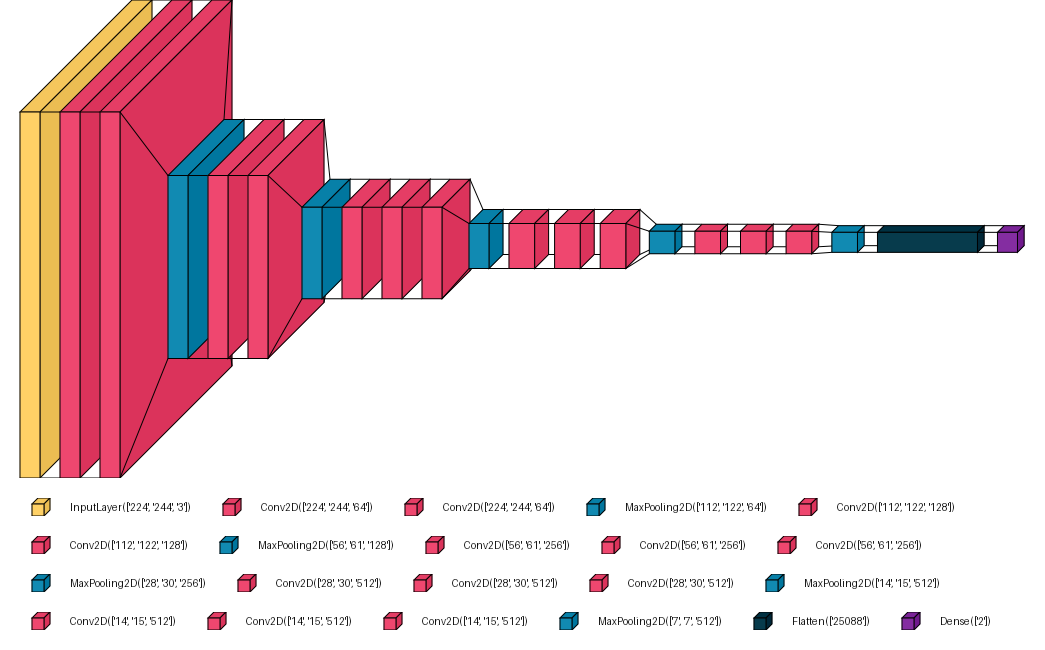

In [9]:
try:
    config = ConfigurationManager()
    prepare_base_model_config = config.get_prepare_base_model_config()
    prepare_base_model = PrepareBaseModel(config=prepare_base_model_config)
    prepare_base_model.get_base_model()
    prepare_base_model.update_base_model()
except Exception as e:
    raise e